In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
import keras
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

In [56]:
BATCH_SIZE = 5
TIME_STEPS = 20
FEATURES_COUNT = 11
EPOCH = 15
TRAIN_NUM = 1000
VALIDATION_NUM = 250
TEST_NUM = 250
SUBJECT = "부광약품"

def normalize_dataframe(df):
    for column in df:
        window = df[column].values.reshape(-1, 1)
        min_v = min(window)
        normalized_window = np.array([((float(p) / float(min_v)) - 1) for p in window]).reshape(len(df), 1)
        df[column] = normalized_window
    return df

def denormalize(arr, fit):
    arr = np.array(arr).reshape(1,-1)
    min_v = min(fit)
    denormalized = [ (i+1) * min_v for i in arr]
    return denormalized

def diff_to_percent(stock):
    res = []
    diff = stock['Diff'].values.reshape(-1,1)
    close = stock['Close'].values.reshape(-1,1)
    for i in range(len(diff)):
        if i == 0:
            res.append([0])
            continue
        res.append((close[i]-close[i-1])/close[i-1] *100)
    res = np.array(res)
    return res.flatten()

def create_dataset(data):
    dataY = []
    dataX = []
    for i in range(len(data)-TIME_STEPS):
        dataX.append(data[i:(i+TIME_STEPS), :FEATURES_COUNT])
        dataY.append(data[i + TIME_STEPS, -1]) # loc of Diff
    return np.array(dataX), np.array(dataY)

def adjust_index(small, big, col_idx, num):
    big.index = [ a[:7] for a in big.index]

    for c in small.columns:
        big[c]= small[c]

    for i, s in enumerate(small.index):
        if i == 0:
            start = 0
        df_small = small.loc[s].to_frame().T
        num = len([b for b in big.index if b == s])
        big.iloc[start:start+num, col_idx:col_idx+num+1] = df_small
        start += num
    return big

def remove_str_from_row(string, row, cols):
    for col in cols:
        row[col] = float(row[col].replace(string, ''))
    return row

stock = pd.read_csv('./stock/{s}/{s}.csv'.format(s=SUBJECT))
stock.columns = ['Date', 'Close','Open', 'High', 'Low', 'Volume', 'IndividualBuying','ForeignerBuying','InstitutionBuying', 'ForeignerHolding', 'InstitutionHolding', 'Diff','Change' ]
stock = stock.set_index('Date').dropna()
stock['Diff'] = [d[-2] * -1 if d[-1] == 'FALL' or d[-1] == 'LOWER_LIMIT' else d[-2] for d in stock.values ]
stock = stock.drop(['Change'], axis=1)
stock = stock.sort_index()
stock['Diff'] = diff_to_percent(stock)

In [57]:
stock = stock[['Diff','Open','High','Low','Volume', 'IndividualBuying', 'ForeignerBuying', 'InstitutionBuying', 'ForeignerHolding', 'InstitutionHolding','Close']]
cp_stock = stock.copy()
stock = normalize_dataframe(stock)
stock = stock.fillna(method='ffill')


In [58]:

train = stock[0:TRAIN_NUM]
val = stock[TRAIN_NUM:TRAIN_NUM+VALIDATION_NUM]
test = stock[TRAIN_NUM+VALIDATION_NUM:]

In [59]:
# In[7]:


x_train, y_train = create_dataset(train.to_numpy())
x_val, y_val = create_dataset(val.to_numpy())
x_test, y_test = create_dataset(test.to_numpy())


# In[8]:


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], FEATURES_COUNT))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], FEATURES_COUNT))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], FEATURES_COUNT))

In [60]:
json_file = open("부광약품_model", "r")
loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("./stock/{s}/{s}_weight".format(s=SUBJECT))

In [61]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (5, 20, 64)               19456     
_________________________________________________________________
dropout_1 (Dropout)          (5, 20, 64)               0         
_________________________________________________________________
lstm_2 (LSTM)                (5, 64)                   33024     
_________________________________________________________________
dropout_2 (Dropout)          (5, 64)                   0         
_________________________________________________________________
dense_1 (Dense)              (5, 1)                    65        
Total params: 52,545
Trainable params: 52,545
Non-trainable params: 0
_________________________________________________________________


In [62]:
pred = loaded_model.predict(x_test[-BATCH_SIZE:], batch_size=BATCH_SIZE)


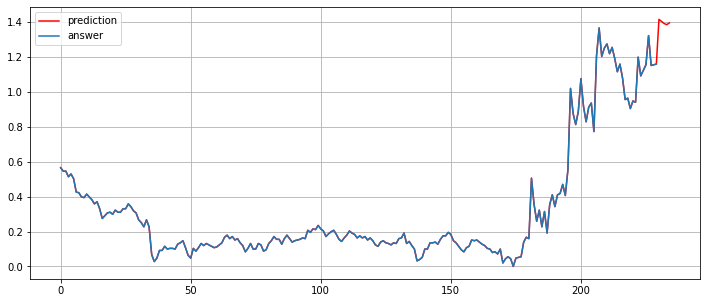

In [63]:
y_t = list(y_test.reshape(1,-1))[0]
p = list(pred.reshape(1,-1)[0])
c = np.hstack([y_t, p])
plt.figure(figsize=(12, 5))
plt.plot( c, 'r', label="prediction")
plt.plot(y_test, label="answer")
plt.grid(b=True, which='both', axis='both')
plt.legend()
plt.show()
plt.close()

In [67]:
print(denormalize(y_t, cp_stock['Close']))
print(len(p))

12550.0
[array([19650., 19400., 19400., 19000., 19200., 18850., 17900., 17850.,
       17550., 17500., 17750., 17550., 17350., 17050., 17200., 16700.,
       16000., 16200., 16400., 16450., 16300., 16600., 16450., 16450.,
       16700., 16700., 17050., 16850., 16550., 16400., 15900., 15700.,
       15400., 15900., 15400., 13400., 12900., 13150., 13700., 13700.,
       14000., 13800., 13850., 13850., 13800., 14150., 14250., 14400.,
       13900., 13350., 13150., 13850., 13650., 13900., 14200., 14050.,
       14200., 14100., 14000., 13900., 13950., 14100., 14250., 14650.,
       14800., 14550., 14700., 14450., 14550., 14250., 14050., 13600.,
       13850., 14200., 13800., 13800., 14200., 14100., 13650., 13750.,
       14200., 14400., 14700., 14500., 14500., 14150., 14550., 14800.,
       14550., 14300., 14400., 14450., 14500., 14600., 14550., 15150.,
       15000., 15250., 15200., 15500., 15250., 15100., 14700., 14900.,
       15050., 15150., 14850., 14500., 14350., 14600., 14800., 15100